In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, confusion_matrix, r2_score
from sklearn.inspection import permutation_importance
import shap
from sklearn.linear_model import LinearRegression, LogisticRegression


df = pd.read_csv('weight_change_dataset.csv')
df.head()

,Participant ID,Age,Gender,Current Weight (lbs),BMR (Calories),Daily Calories Consumed,Daily Caloric Surplus/Deficit,Weight Change (lbs),Duration (weeks),Physical Activity Level,Sleep Quality,Stress Level,Final Weight (lbs)
0,1,56,M,228.4,3102.3,3916.0,813.7,0.2,1,Sedentary,Excellent,6,228.6
1,2,46,F,165.4,2275.5,3823.0,1547.5,2.4,6,Very Active,Excellent,6,167.8
2,3,32,F,142.8,2119.4,2785.4,666.0,1.4,7,Sedentary,Good,3,144.2
3,4,25,F,145.5,2181.3,2587.3,406.0,0.8,8,Sedentary,Fair,2,146.3
4,5,38,M,155.5,2463.8,3312.8,849.0,2.0,10,Lightly Active,Good,1,157.5


In [54]:
df.columns

Index(['Participant ID', 'Age', 'Gender', 'Current Weight (lbs)',
       'BMR (Calories)', 'Daily Calories Consumed',
       'Daily Caloric Surplus/Deficit', 'Weight Change (lbs)',
       'Duration (weeks)', 'Physical Activity Level', 'Sleep Quality',
       'Stress Level', 'Final Weight (lbs)'],
      dtype='object')

In [55]:
df.columns = df.columns.str.replace(' ', '_')

df.columns

Index(['Participant_ID', 'Age', 'Gender', 'Current_Weight_(lbs)',
       'BMR_(Calories)', 'Daily_Calories_Consumed',
       'Daily_Caloric_Surplus/Deficit', 'Weight_Change_(lbs)',
       'Duration_(weeks)', 'Physical_Activity_Level', 'Sleep_Quality',
       'Stress_Level', 'Final_Weight_(lbs)'],
      dtype='object')

In [56]:
df = df.drop('Participant_ID', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            100 non-null    int64  
 1   Gender                         100 non-null    object 
 2   Current_Weight_(lbs)           100 non-null    float64
 3   BMR_(Calories)                 100 non-null    float64
 4   Daily_Calories_Consumed        100 non-null    float64
 5   Daily_Caloric_Surplus/Deficit  100 non-null    float64
 6   Weight_Change_(lbs)            100 non-null    float64
 7   Duration_(weeks)               100 non-null    int64  
 8   Physical_Activity_Level        100 non-null    object 
 9   Sleep_Quality                  100 non-null    object 
 10  Stress_Level                   100 non-null    int64  
 11  Final_Weight_(lbs)             100 non-null    float64
dtypes: float64(6), int64(3), object(3)
memory usage: 9.

In [57]:
df.isnull().sum()

Age                              0
Gender                           0
Current_Weight_(lbs)             0
BMR_(Calories)                   0
Daily_Calories_Consumed          0
Daily_Caloric_Surplus/Deficit    0
Weight_Change_(lbs)              0
Duration_(weeks)                 0
Physical_Activity_Level          0
Sleep_Quality                    0
Stress_Level                     0
Final_Weight_(lbs)               0
dtype: int64

In [58]:
df = df.copy()

# Encode 'Gender'
df['Gender'] = df['Gender'].map({'M': 0, 'F': 1})

# Encode 'Physical Activity Level'
activity_mapping = {'Sedentary': 0, 'Lightly Active': 1,
                    'Moderately Active': 2, 'Very Active': 3}
df['Physical_Activity_Level'] = df['Physical_Activity_Level'].map(
    activity_mapping)

# Encode 'Sleep Quality'
sleep_mapping = {'Poor': 0, 'Fair': 1, 'Good': 2, 'Excellent': 3}
df['Sleep_Quality'] = df['Sleep_Quality'].map(
    sleep_mapping)

In [59]:
numeric_features = ['Age', 'Current_Weight_(lbs)', 'BMR_(Calories)', 'Daily_Calories_Consumed',
                    'Daily_Caloric_Surplus/Deficit', 'Duration_(weeks)', 'Stress_Level']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the data
df[numeric_features] = scaler.fit_transform(
    df[numeric_features])

In [60]:
df['Physical_Activity_Level'] = df['Physical_Activity_Level'].astype(
    object).astype(int)
df['Sleep_Quality'] = df['Sleep_Quality'].astype(object).astype(int)

In [61]:
df = df.drop(columns=['Final_Weight_(lbs)'])

In [62]:
x = df.drop(['Weight_Change_(lbs)'], axis=1)
y = df['Weight_Change_(lbs)']

x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.2, random_state=23)

In [63]:
y_train = y_train.fillna(0)

numerical_features = x.columns

numeric_transformer = StandardScaler()

In [64]:
preProcess = ColumnTransformer(
    transformers=[('num', numeric_transformer, numerical_features)])

pipeline = Pipeline([('preprocess', preProcess),
                     ('regressor', RandomForestRegressor())])

param_grid = [{'regressor': [RandomForestRegressor()],
               'regressor__max_depth': [1, 2, 3, 4],
              'regressor__n_estimators': [100, 500]}]

In [65]:
random.seed(1)
cv_mine = KFold(n_splits=3)
gridSearch = GridSearchCV(pipeline, param_grid, cv=cv_mine,
                          scoring='r2', n_jobs=-1)
gridSearch.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['Age', 'Gender', 'Current_Weight_(lbs)', 'BMR_(Calories)',
       'Daily_Calories_Consumed', 'Daily_Caloric_Surplus/Deficit',
       'Duration_(weeks)', 'Physical_Activity_Level', 'Sleep_Quality',
       'Stress_Level'],
      dtype='object'))])),
                                       ('regressor', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid=[{'regressor': [RandomForestRegressor()],
                          'regressor__max_depth': [1, 2, 3, 4],
                          'regressor__n_estimators': [100, 500]}],
             scoring='r2')

In [66]:
gridSearch.best_params_

{'regressor': RandomForestRegressor(),
 'regressor__max_depth': 4,
 'regressor__n_estimators': 500}

In [67]:
gridSearch.best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Age', 'Gender', 'Current_Weight_(lbs)', 'BMR_(Calories)',
       'Daily_Calories_Consumed', 'Daily_Caloric_Surplus/Deficit',
       'Duration_(weeks)', 'Physical_Activity_Level', 'Sleep_Quality',
       'Stress_Level'],
      dtype='object'))])),
                ('regressor',
                 RandomForestRegressor(max_depth=4, n_estimators=500))])

In [68]:
best_model = gridSearch.best_estimator_

y_pred = best_model.predict(x_val)
print(r2_score(y_val, y_pred))
print(mean_squared_error(y_val, y_pred))

0.7060436593501678
25.762180388174265


In [69]:
best_model.named_steps

{'preprocess': ColumnTransformer(transformers=[('num', StandardScaler(),
                                  Index(['Age', 'Gender', 'Current_Weight_(lbs)', 'BMR_(Calories)',
        'Daily_Calories_Consumed', 'Daily_Caloric_Surplus/Deficit',
        'Duration_(weeks)', 'Physical_Activity_Level', 'Sleep_Quality',
        'Stress_Level'],
       dtype='object'))]),
 'regressor': RandomForestRegressor(max_depth=4, n_estimators=500)}

In [70]:

feature_importances = best_model.named_steps['regressor'].feature_importances_

print("Best parameters:", gridSearch.best_params_)
print("Feature importances:", feature_importances)

Best parameters: {'regressor': RandomForestRegressor(), 'regressor__max_depth': 4, 'regressor__n_estimators': 500}
Feature importances: [0.02136284 0.00225614 0.02066613 0.02397948 0.01215421 0.03066907
 0.12048781 0.00588308 0.37402693 0.38851431]


In [71]:
rf = best_model.named_steps['regressor']
preprocessor = best_model.named_steps["preprocess"]
rf

RandomForestRegressor(max_depth=4, n_estimators=500)

In [72]:
# adjust "preprocessor" as needed
if hasattr(preprocessor, 'get_feature_names_out'):
    feature_names = preprocessor.get_feature_names_out()
else:
    feature_names = preprocessor.get_feature_names()

In [73]:
feature_names

array(['num__Age', 'num__Gender', 'num__Current_Weight_(lbs)',
       'num__BMR_(Calories)', 'num__Daily_Calories_Consumed',
       'num__Daily_Caloric_Surplus/Deficit', 'num__Duration_(weeks)',
       'num__Physical_Activity_Level', 'num__Sleep_Quality',
       'num__Stress_Level'], dtype=object)

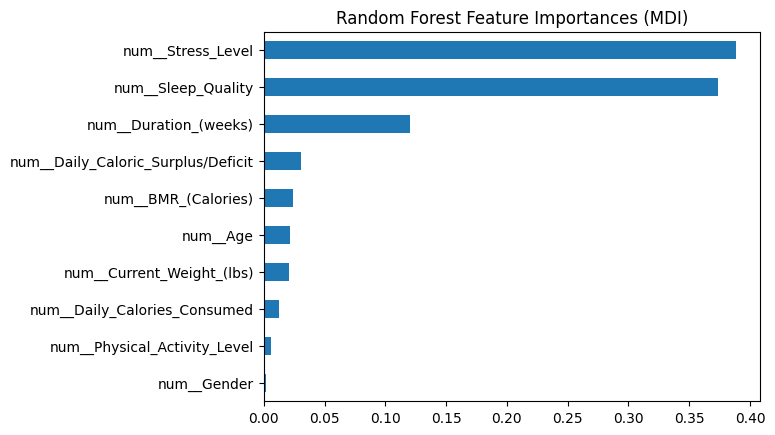

In [74]:
mdi_importances = pd.Series(rf.feature_importances_,
                            index=feature_names).sort_values(ascending=True)

# Plot the importances
ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
plt.show()

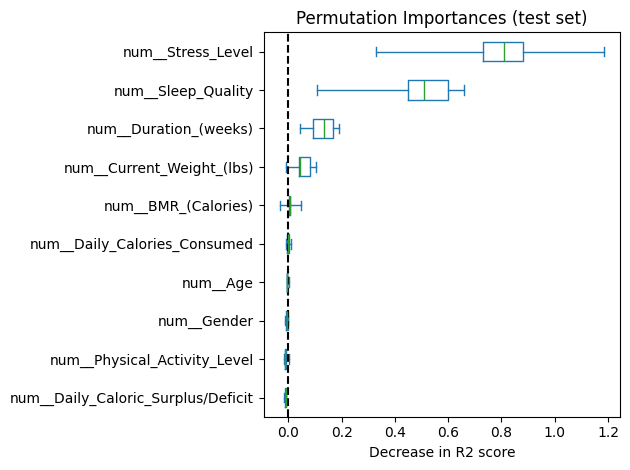

In [75]:
from sklearn.inspection import permutation_importance

# Transform the validation set
X_val_transformed = preprocessor.transform(x_val)

# Create a DataFrame from the transformed validation data
# Get feature names from the preprocessor if it has a feature names attribute
try:
    feature_names = preprocessor.get_feature_names_out()
except AttributeError:
    # Provide custom names if preprocessor lacks `get_feature_names_out`
    feature_names = [f"feature_{i}" for i in range(X_val_transformed.shape[1])]

X_val_transformed_df = pd.DataFrame(X_val_transformed, columns=feature_names)

# Compute permutation feature importance using the test data
result = permutation_importance(
    rf, X_val_transformed, y_val, n_repeats=10, random_state=42, n_jobs=2
)

# Sort importances and prepare a DataFrame for plotting
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_val_transformed_df.columns[sorted_importances_idx],
)

# Plot the permutation feature importance
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in R2 score")

plt.tight_layout()
plt.show()

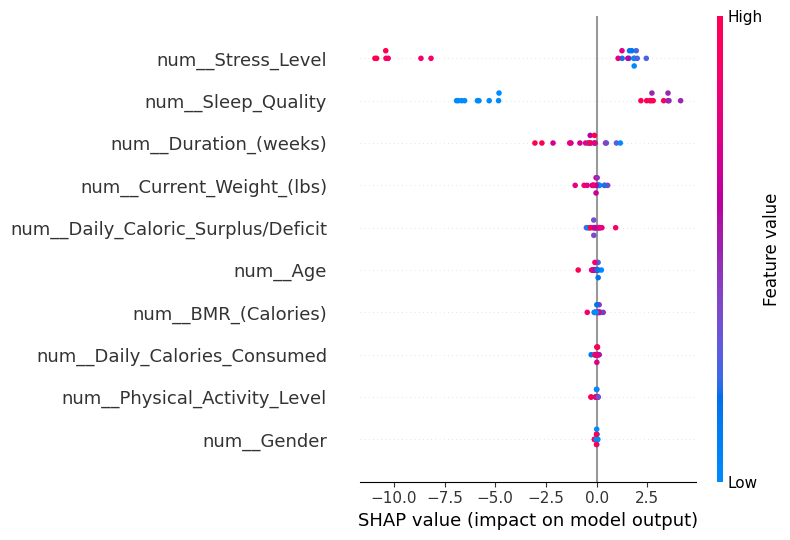

In [76]:
# Plot the SHAP feature importance
X_val_transformed_df = pd.DataFrame(X_val_transformed, columns=feature_names)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_val_transformed_df)
shap.summary_plot(shap_values, X_val_transformed_df)

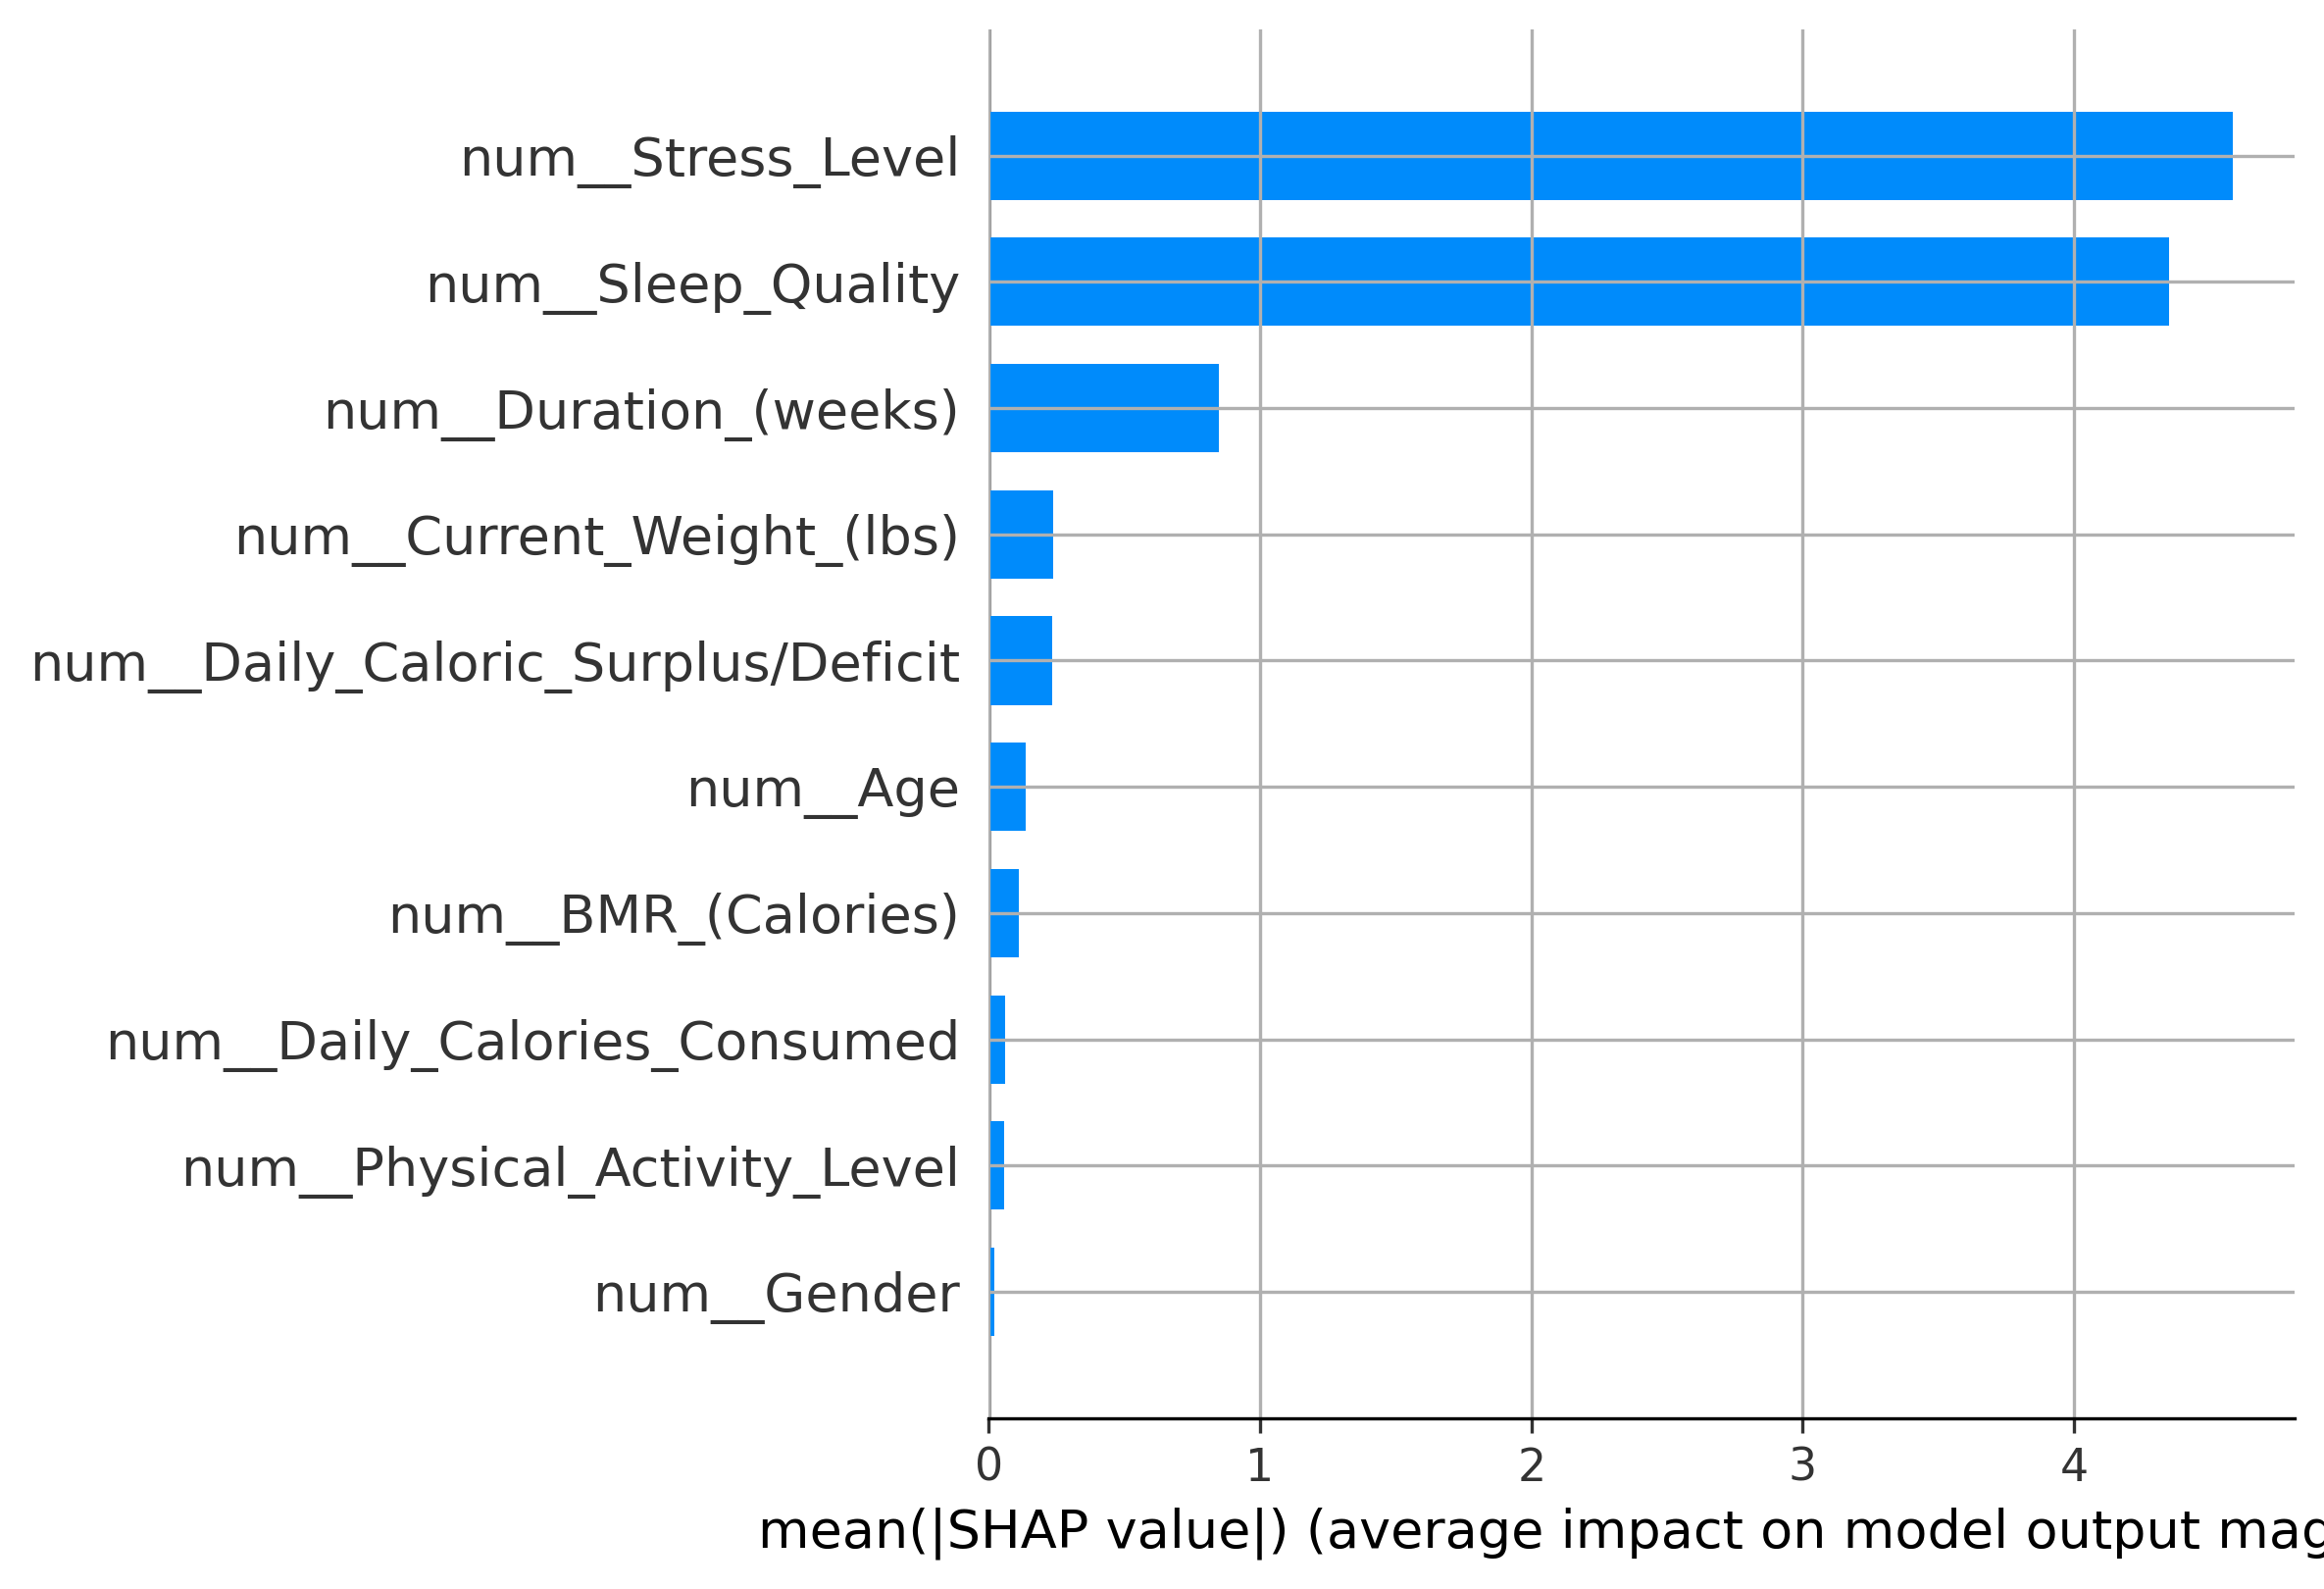

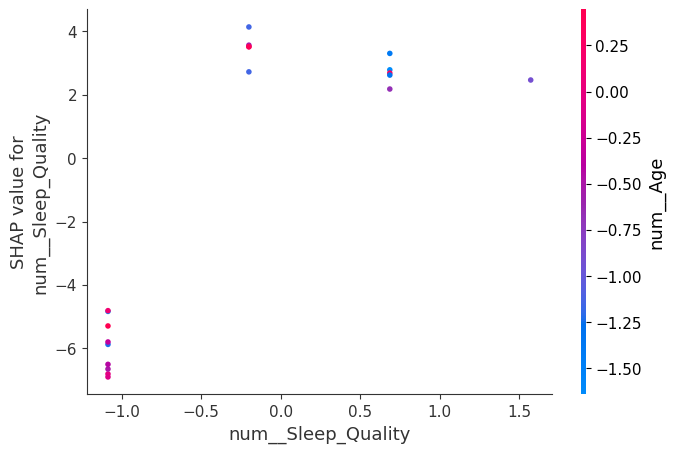

In [77]:
fig = plt.figure(figsize=(6, 3.3), dpi=300)
shap.summary_plot(shap_values, X_val_transformed_df,
                  plot_type="bar", show=False)
plt.grid()
shap.dependence_plot("num__Sleep_Quality", shap_values, X_val_transformed_df)

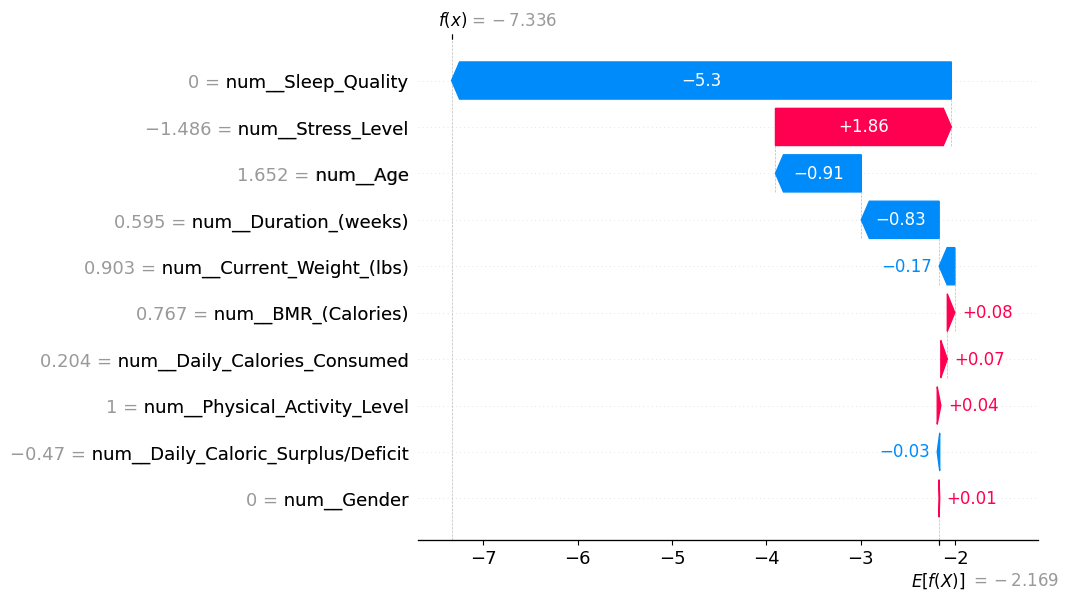

In [78]:
fig = plt.figure(figsize=(6, 3.3))
explanation5 = shap.Explanation(values=shap_values[4], base_values=explainer.expected_value[0],
                                feature_names=X_val_transformed_df.columns, data=x_val.iloc[4, :])
shap.plots.waterfall(explanation5)
fig.tight_layout()